In [15]:
#!apt-get --purge remove cuda nvidia* libnvidia-*
#!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
#!apt-get remove cuda-*
#!apt autoremove
#!apt-get update

In [16]:
"""!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2"""


'!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb\n!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb\n!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub\n!apt-get update\n!apt-get install cuda-9.2'

In [17]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D
from numba import cuda
from numba import *
from IPython.display import clear_output

In [18]:
def plot_contour(x, y, p, u, v):
    fig = plt.figure(figsize = (11, 7), dpi = 100)
    X, Y = np.meshgrid(x, y)
    
    #Velocity field
    plt.quiver(X[::5, ::5], Y[::5, ::5], u[::5, ::5], v[::5, ::5])
    
    plt.xlabel('X')
    plt.ylabel('Y');

In [19]:
@jit(parallel = True, cache = True)
def buildB(b, rho, dt, u, v, dx, dy):
    dy2 = dy**2
    dx2 = dx**2
    dx2y2 = dy2 * dx2 
    sumdx2y2 = dy2 + dx2
    b[1:-1,1:-1] = dx2y2 / (2 * (sumdx2y2)) * (rho * (1 / dt *
                   ((u[1:-1,2:] - u[1:-1,0:-2]) / (2 * dx) +
                    (v[2:,1:-1] - v[0:-2,1:-1]) / (2 * dy)) -
                     ((u[1:-1,2:] - u[1:-1,0:-2]) / (2 * dx))**2 -
                       2 * ((u[2:,1:-1] - u[0:-2,1:-1]) / (2 * dy) *
                            (v[1:-1,2:] - v[1:-1,0:-2]) / (2 * dx)) -
                          ((v[2:,1:-1] - v[0:-2,1:-1]) / (2 * dy))**2))
    
    #periodic BC pressure @x = 2
    b[1:-1,-1] = dx2y2 / (2 * (sumdx2y2)) * (rho * (1 / dt *
                   ((u[1:-1,0] - u[1:-1,-2]) / (2 * dx) +
                    (v[2:,-1] - v[0:-2,-1]) / (2 * dy)) -
                     ((u[1:-1,0] - u[1:-1,-2]) / (2 * dx))**2 -
                       2 * ((u[2:,-1] - u[0:-2,-1]) / (2 * dy) *
                            (v[1:-1,0] - v[1:-1,-2]) / (2 * dx)) -
                          ((v[2:,-1] - v[0:-2,-1]) / (2 * dy))**2))
    
    # Periodic BC Pressure @ x = 0
    b[1:-1,0] = dx2y2 / (2 * (sumdx2y2)) * (rho * (1 / dt *
                   ((u[1:-1,1] - u[1:-1,-14]) / (2 * dx) +
                    (v[2:,0] - v[0:-2,0]) / (2 * dy)) -
                     ((u[1:-1,1] - u[1:-1,-1]) / (2 * dx))**2 -
                       2 * ((u[2:,0] - u[0:-2,0]) / (2 * dy) *
                            (v[1:-1,1] - v[1:-1,-1]) / (2 * dx)) -
                          ((v[2:,0] - v[0:-2,0]) / (2 * dy))**2))
    #print(b)
    return b

In [20]:
cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      compute capability: 7.5
                           pci device id: 4
                              pci bus id: 0
Summary:
	1/1 devices are supported


True

In [21]:
@jit(nopython = True)
def gamma_cal(u, v, dx, dy):
    S_11 = np.zeros_like((v))
    S_12 = np.zeros_like((v))
    S_22 = np.zeros_like((v))

    # For b[1:-1, 1:-1] 
    S_11[1:-1, 1:-1]  = ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))
    S_12[1:-1, 1:-1] = (1/2)*(((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy)) + ((v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx)) )
    S_22[1:-1, 1:-1]  = ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))

    ## Boundary conditions x = 2
    S_11[1:-1,-1]  = ((u[1:-1,0] - u[1:-1,-2]) / (2 * dx))
    S_12[1:-1, -1] = (1/2)*(((u[2:,-1] - u[0:-2,-1]) / (2 * dy)) + ((v[1:-1, 0] - v[1:-1, -2]) / (2 * dx)) )
    S_22[1:-1, -1]  = ((v[2:, -1] - v[0:-2, -1]) / (2 * dy))
    
    #Boundary Conditions x = 0 
    S_11[1:-1, 0]  = ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx))
    S_12[1:-1, 0] = (1/2)*(((u[2:, 0] - u[0:-2, 0]) / (2 * dy)) + ((v[1:-1, 1] - v[1:-1, -1]) / (2 * dx)) )
    S_22[1:-1, 0]  = ((v[2:, 0] - v[0:-2, 0]) / (2 * dy))
 
    #y = 0
    S_11[0,:] = 0 # no slip condition means u = 0 S_11[1,:]#
    S_12[0,:] = ((u[1,:] - u[0,:]) / (dx))      
    #S_12[1,:]# Forward Difference applied since there is no element before 0th element.
    #V terms are removed since impermeable wall BC is used rendering V = 0 at the wall
                                                
    S_22[0,:] = ((v[1,:] - v[0,:]) / (dy))#S_22[1,:]#
    
    #y = 2
    S_11[-1,:] = 0  # no slip condition means u = 0#S_11[-2,:]#
    S_12[-1,:] = ((u[-1,:] - u[-2,:]) / (dx))   
    ##S_12[-2,:]# Forward Difference applied since there is no element after -1st element.
    #V terms are removed since impermeable wall BC is used rendering V = 0 at the wall
                                                
    S_22[-1,:] = ((v[-1,:] - v[-2,:]) / (dy)) #S_22[-2,:]#
    
    #print(S_11, S_22, S_12)
    #gamma_dot =  9*np.sqrt(( np.square(S_11) + np.square(S_22) + 2*np.square(S_12)))
    gamma_dot = np.sqrt(2*(np.square(S_11) + np.square(S_22) + 2*np.square(S_12)))
    
    #print("gamma_dot:", gamma_dot)
    return gamma_dot, S_11, S_12, S_22


In [22]:
@jit(nopython = True)
def nufunc(nu_0, nu_inf, m, n, gamma):
    #nu_0 = 0.001 #limiting range of kinematic viscosity at 0
    #nu_inf = 0.0014 #limiting range of kinematic viscocity at infinity
    #m = 10e-4 # Non-newtonion flow parameter
    #n = 1.2
    nu1 = np.empty_like((gamma))
    #Truncated Power Law
    # For certain value of n
    h = gamma.shape[0]
    w = gamma.shape[1]
    
    if n == 1:
        nu1[:,:] = nu_inf
        return nu1
    gamma_0 = (nu_0/m)**(1/(n-1))
    gamma_inf = ( nu_inf/m)**(1/(n-1))
    for i in range(w):
        for j in range(h):
            if (gamma[j,i] < gamma_0):
                nu1[j,i] = nu_0
            elif ((gamma[j,i] > gamma_0) and (gamma_inf >= gamma[j,i])):
                nu1[j,i] = m*(gamma[j,i])**(n - 1)
            elif (gamma[j,i] > gamma_inf):
                nu1[j,i] = nu_inf

    #print( gamma_0)
    #print( gamma_inf)
    #print(gamma)
    #nu1 = nu1*10
    return nu1

In [23]:
@jit(nopython = True)
def uv(u, v, p, nu1, dx, dy, dt, F, rho):
  un = u.copy()
  vn = v.copy()
  u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                 un[1:-1, 1:-1] * dt / dx *
                 (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                 vn[1:-1, 1:-1] * dt / dy *
                 (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                 dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) 
                 +(dt / (2 * dx**2) * (nu1[1:-1,2:] - nu1[1:-1,0:-2]) * (un[1:-1,2:] - un[1:-1,0:-2]))
                 +(2 * dt / (dx**2) * nu1[1:-1,1:-1] * (un[1:-1,2:] - 2 * un[1:-1,1:-1] + un[1:-1,0:-2])) 
                 +(dt / (4 * dy**2) * (nu1[2:,1:-1] - nu1[0:-2,1:-1]) * (un[2:,1:-1] - un[0:-2,1:-1]))
                 +(dt / (dy**2) * nu1[1:-1,1:-1] * (un[2:,1:-1] - 2 * un[1:-1,1:-1] + un[0:-2,1:-1]))
                 +(dt / (4 * dx * dy) * (nu1[2:,1:-1] - nu1[0:-2,1:-1]) * (vn[1:-1,2:] - vn[1:-1,0:-2]))
                 +((dt * nu1[1:-1,1:-1 ]) / (4 * dx * dy) * ((vn[2:,2:] - vn[0:-2,2:]) - (vn[2:,0:-2] - vn[0:-2,0:-2]) )) + F * dt )


  v[1:-1, 1:-1] = (vn[1:-1, 1:-1]-
                 un[1:-1, 1:-1] * dt / dx *
                 (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                 vn[1:-1, 1:-1] * dt / dy *
                 (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                 dt / (2 * rho * dy) * (p[1:-1, 2:] - p[1:-1, 0:-2]) 
                 +(dt / (4 * dx**2) * (nu1[1:-1,2:] - nu1[1:-1,0:-2]) * (vn[1:-1,2:] - vn[1:-1,0:-2]))                 
                 +(dt / (dx**2) * nu1[1:-1,1:-1] * (vn[1:-1,2:] - 2 * vn[1:-1,1:-1] + vn[1:-1,0:-2]))                 
                 +(dt / (2 * dy**2) * (nu1[2:,1:-1] - nu1[0:-2,1:-1]) * (vn[2:,1:-1] - vn[0:-2,1:-1]))                 
                 +( 2 * dt / (dy**2) * nu1[1:-1,1:-1] * (vn[2:,1:-1] - 2 * vn[1:-1,1:-1] + vn[0:-2,1:-1]))                 
                 +(dt / (4 * dx * dy) * (nu1[1:-1,2:] - nu1[1:-1,0:-2]) * (un[2:,1:-1] - un[0:-2,1:-1]))                 
                 +((dt * nu1[1:-1,1:-1]) / (4 * dx * dy) * ((un[2:,2:] - un[2:,0:-2]) - (vn[0:-2,2:] - vn[0:-2,0:-2]) )))

  # Periodic BC u @ x = 2     
  u[1:-1,-1] = (un[1:-1,-1]-
                 un[1:-1,-1] * dt / dx *
                 (un[1:-1,-1] - un[1:-1, -2]) -
                 vn[1:-1,-1] * dt / dy *
                 (un[1:-1,-1] - un[0:-2,-1]) -
                 dt / (2 * rho * dx) * (p[1:-1,0] - p[1:-1, -2]) 
                 +(dt / (2 * dx**2) * (nu1[1:-1,0] - nu1[1:-1, -2]) * (un[1:-1,0] - un[1:-1, -2]))              
                 +(2 * dt / (dx**2) * nu1[1:-1,-1] * (un[1:-1,0] - 2 * un[1:-1,-1] + un[1:-1, -2]))              
                 +(dt / (4 * dy**2) * (nu1[2:,-1] - nu1[0:-2,-1]) * (un[2:,-1] - un[0:-2,-1]))              
                 +(dt / (dy**2) * nu1[1:-1,-1] * (un[2:,-1] - 2 * un[1:-1,-1] + un[0:-2,-1]))              
                 +(dt / (4 * dx * dy) * (nu1[2:,-1] - nu1[0:-2,-1]) * (vn[1:-1,0] - vn[1:-1, -2]))              
                 +((dt * nu1[1:-1,-1]) / (4 * dx * dy) * ((vn[2:,0] - vn[0:-2,0]) - (vn[2:, -2] - vn[0:-2, -2]) )) + F * dt)

  # Periodic BC u @ x = 0
  u[1:-1, 0] = (un[1:-1, 0]-
                 un[1:-1, 0] * dt / dx *
                 (un[1:-1, 0] - un[1:-1, -1]) -
                 vn[1:-1, 0] * dt / dy *
                 (un[1:-1, 0] - un[0:-2, 0]) -
                 dt / (2 * rho * dx) * (p[1:-1, 1] - p[1:-1, -1]) 
                 +(dt / (2 * dx**2) * (nu1[1:-1,1] - nu1[1:-1,-1]) * (un[1:-1,1] - un[1:-1,-1]))              
                 +(2 * dt / (dx**2) * nu1[1:-1,0] * (un[1:-1,1] - 2 * un[1:-1,0] + un[1:-1,-1]))              
                 +(dt / (4 * dy**2) * (nu1[2:,0] - nu1[0:-2,0]) * (un[2:,0] - un[0:-2,0]))              
                 +(dt / (dy**2) * nu1[1:-1,0] * (un[2:,0] - 2 * un[1:-1,0] + un[0:-2,0]))              
                 +(dt / (4 * dx * dy) * (nu1[2:,0] - nu1[0:-2,0]) * (vn[1:-1,1] - vn[1:-1,-1]))              
                 +((dt * nu1[1:-1,0]) / (4 * dx * dy) * ((vn[2:,1] - vn[0:-2,1]) - (vn[2:,-1] - vn[0:-2,-1]) )) + F * dt)

  # Periodic BC v @ x = 2
  v[1:-1,-1] = (vn[1:-1,-1]-
                      un[1:-1,-1] * dt / dx *
                      (vn[1:-1,-1] - vn[1:-1,-2]) -
                      vn[1:-1,-1] * dt / dy *
                      (vn[1:-1,-1] - vn[0:-2,-1]) -
                      dt / (2 * rho * dy) * (p[1:-1,0] - p[1:-1,-2]) 
                      +(dt / (4 * dx**2) * (nu1[1:-1,0] - nu1[1:-1,-2]) * (vn[1:-1,0] - vn[1:-1,-2]))                 
                      +(dt / (dx**2) * nu1[1:-1,-1] * (vn[1:-1,0] - 2 * vn[1:-1,-1] + vn[1:-1,-2]))                 
                      +(dt / (2 * dy**2) * (nu1[2:,-1] - nu1[0:-2,-1]) * (vn[2:,-1] - vn[0:-2,-1]))                 
                      +( 2 * dt / (dy**2) * nu1[1:-1,-1] * (vn[2:,-1] - 2 * vn[1:-1,-1] + vn[0:-2,-1]))                 
                      +(dt / (4 * dx * dy) * (nu1[1:-1,0] - nu1[1:-1,-2]) * (un[2:,-1] - un[0:-2,-1]))                 
                      +((dt * nu1[1:-1,-1 ]) / (4 * dx * dy) * ((un[2:,0] - un[2:,-2]) - (vn[0:-2,0] - vn[0:-2,-2]) )))

  # Periodic BC v @ x = 0
  v[1:-1,0] = (vn[1:-1,0]-
                    un[1:-1,0] * dt / dx *
                    (vn[1:-1,0] - vn[1:-1,-1]) -
                    vn[1:-1,0] * dt / dy *
                    (vn[1:-1,0] - vn[0:-2,0]) -
                    dt / (2 * rho * dy) * (p[1:-1,1] - p[1:-1,-1]) 
                    +(dt / (4 * dx**2) * (nu1[1:-1,1] - nu1[1:-1,-1]) * (vn[1:-1,1] - vn[1:-1,-1]))                 
                    +(dt / (dx**2) * nu1[1:-1,0] * (vn[1:-1,1] - 2 * vn[1:-1,0] + vn[1:-1,-1]))                 
                    +(dt / (2 * dy**2) * (nu1[2:,0] - nu1[0:-2,0]) * (vn[2:,0] - vn[0:-2,0]))                 
                    +( 2 * dt / (dy**2) * nu1[1:-1,0] * (vn[2:,0] - 2 * vn[1:-1,0] + vn[0:-2,0]))                 
                    +(dt / (4 * dx * dy) * (nu1[1:-1,1] - nu1[1:-1,-1]) * (un[2:,0] - un[0:-2,0]))                 
                    +((dt * nu1[1:-1,0 ]) / (4 * dx * dy) * ((un[2:,1] - un[2:,-1]) - (vn[0:-2,1] - vn[0:-2,-1]) )))


  # Wall BC: u,v = 0 @ y = 0,2
  u[0, :] = 0
  u[-1, :] = 0
  v[0, :] = 0
  v[-1, :]=0
  return u, v


In [24]:
@cuda.jit('void(float32[:,:], float32[:,:], float32[:,:], float32, float32, float32[:,:])')
def pres_poisson(p, pn, b, dx, dy, pdiff):
    dy2 = dy**2
    dx2 = dx**2
    sumdx2dy2 = dy2 + dx
    height = p.shape[0]
    width = p.shape[1]
    
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;
    for i in range(50):
        pn = p
        for x in range((startX + 1) , (width - 1), gridX):
            for y in range((startY + 1), (height - 1), gridY):
                p[y,x] = (((pn[y,(x+1)] + pn[y,(x-1)]) * dy2 +
                (pn[(y+1),x] + pn[(y-1),x]) * dx2 ) /
                (2 * sumdx2dy2)) - b[y,x]
        
            # Wall BC pressure
            p[0,x] = p[1,x]     # dp/dy = 0 at y = 0
            p[-1,x] = p[-2,x]   # dp/dy = 0 at y = 
        # Periodic BC pressure @ x = 2
        for y in range((startY), (height), gridY):
            p[y,-1] = (((pn[y,0] + pn[y,-2]) * dy2 +
                           (pn[(y+1),-1] + pn[(y-1),-1]) * dx2) / 
                          (2 * (sumdx2dy2)) - b[y,-1])
            p[y,0] = (((pn[y,1] + pn[y,-1]) * dy2 +
                          (pn[(y+1),0] + pn[(y-1),0]) * dx2) /
                         (2 * (sumdx2dy2)) - b[y,0])
        
        for x in range((startX) , (width), gridX):
            for y in range((startY), (height), gridY):
              pdiff[y,x] = abs(p[y,x] -pn[y,x])
     


In [25]:

def channel_flow(udiff_target,F, u, v, dx, dy, p, b, rho, nu_0, nu_inf, m, n):
    udiff = 10
    stepcount = 0
    un = np.empty_like(u)
    vn = np.empty_like(v)
    pn = np.empty_like(p)
    #b = np.zeros((ny, nx))
    gamma_dot, S11, S12, S22 = gamma_cal(u, v, dx, dy)
    plotpdiff = np.array([])
    pdiff = np.empty_like(p)
    
    while udiff > udiff_target:
        un = u.copy()
        vn = v.copy()
        ## setting time step with max viscosity
        gamma_dot, S11, S12, S22 = gamma_cal(u, v, dx, dy)
        nu1 = nufunc(nu_0, nu_inf, m, n, gamma_dot)
        
        nu_max = np.max(nu1)
        sigma = .5
        dt = sigma * dx * dy / nu_max
        
        dtx = dt / dx
        dty = dt / dy
        dtx2 = dt / dx**2
        dty2 = dt / dy**2
        
        
        b = buildB(b, rho, dt, u, v, dx, dy)
        blockdim = (9,9)#(13, 3)
        griddim = (11,11) #(3, 13)
        
        

        d_b = cuda.to_device(b)
        d_p = cuda.to_device(p)
        d_pn = cuda.to_device(pn)
        d_pdiff = cuda.to_device(pdiff)
        pres_poisson[griddim, blockdim](p, pn, b, dx, dy, pdiff)
        d_pdiff.to_host()
        d_b.to_host()
        d_p.to_host()
        d_pn.to_host()
        
        u , v = uv(u, v, p, nu1, dx, dy, dt, F, rho)


        udiffprev = udiff
        udiff = np.sum(np.abs(u -un))
        udiffdelta = udiff - udiffprev 
        stepcount += 1
        if stepcount%100 == 0:
          plotpdiff = np.append(plotpdiff, np.sum(pdiff))
        if stepcount%20 == 0:
          A = np.max(u)
          clear_output(wait=True)
          print(stepcount, udiff, A, dt, flush=True)
    print(stepcount)
    fig1 = plt.figure(figsize=(11, 7), dpi=100)
    plt.plot(gamma_dot[:,20], marker = '.', lw=0.5, label='gamma_dot')
    plt.legend()
    fig2 = plt.figure(figsize=(11, 7), dpi=100)
    plt.plot(nu1[:,20], marker = '.', lw=0.5, label='nu1')
    fig3 = plt.figure(figsize = (11, 7), dpi = 100)
    plt.plot(plotpdiff, lw = 0.5, label = 'pdiff')
    plt.legend()
    #print(stepcount * dt)
    A = np.max(u)
    print("U_maximum:", np.max(u))
    return u, v, p, nu1, gamma_dot, S11, S12, S22, plotpdiff

In [35]:
@jit(nopython = True)
def nonNewtanalytical(n, H,ny):
    #H = 2
    b = H
    U0 = 0.04#			% Avg inlet velocity
    #n = 2  #          % power law index

    U_max = (2*n+1)/(n+1)*U0


    Re = 40            
    m = U0**(2-n) * H**n / Re 

    G = m*U_max**n*((n+1)/n)**n*(2/H)**(n+1)

    UMAX = n/(n+1)*(G/m)**(1/n)*(b/2)**((n+1)/n)

    y=np.linspace(0,H,ny)
    u = np.zeros(ny)

    if n<1:
        nu_0 = 0.1
        nu_inf = 0.001


    if n>=1:
        nu_0 = 0.001
        nu_inf = 0.1

    if n!= 1:
        z_h = b/2 - (nu_inf/(m**(1/n)))**(n/(n-1))/G

        z_l = b/2 - (nu_0/(m**(1/n)))**(n/(n-1))/G
    else:
        z_h = b/2
        z_l = b/2


    alpha_1 = G/(2*nu_inf)*z_h*(b-z_h) - n/(n+1)*(G/m)**(1/n)*((b/2)**((n+1)/n)-(b/2-z_h)**((n+1)/n))

    if z_h<0:  
        z_h = 0
        alpha_1 = 0



    alpha_2 = (n/(n+1))*(G/m)**(1/n)*((b/2)**((n+1)/n)-(b/2-z_l)**((n+1)/n)) - (G/(2*nu_0))*z_l*(b-z_l) + alpha_1

    if z_l<0:
        alpha_2=0
        z_l=0



    for i in  range(ny):

        if ((y[i]>=0) and (y[i]<=z_h)) or ((y[i]>=b-z_h) and (y[i]<=b)):

            u[i] = (G/(2*nu_inf))*y[i]*np.abs((b-y[i]))



        elif ((y[i]>z_h) and (y[i]<z_l)) or ((y[i]>=b-z_l) and (y[i]<b-z_h)):

            u[i] = n/(n+1)*(G/m)**(1/n)*((b/2)**((n+1)/n) - np.abs((b/2-y[i]))**((n+1)/n)) + alpha_1



        elif ((y[i]>=z_l) and (y[i]<b/2)) or ((y[i]>=b/2) and (y[i]<b-z_l)):

            u[i] = (G/(2*nu_0))*y[i]*np.abs((b-y[i])) + alpha_2





    #u1 = (G/m)**(1/n)*(n/(n+1))*((H/2)**((n+1)/n)-np.abs((H/2-y))**((n+1)/n))

    #figure(1)
    #plt.plot(y,u1, label = 'Power')
    #plt.legend()
    #plt.plot(y,u, label = 'Truncated')
    return G, m, nu_0, nu_inf, u

In [27]:
def chn_sim_run(n,udiff_target):
    
    nx = 34
    ny = nx
    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    x = np.linspace(0, 2, nx)
    y = np.linspace(0, 2, ny)

    rho = 1
    
    #F = 1.7881e-4

    #nu_0 = 0.1 #limiting range of kinematic viscosity at 0
    #nu_inf = 0.001 #limiting range of kinematic viscocity at infinity
    #m = 9.1461e-4 # Non-newtonion flow parameter
    #n = 1.2
    G, m, nu_0, nu_inf, vel_anal= nonNewtanalytical(n,2,ny)


    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))
    b = np.zeros((ny, nx))

    u, v, p, nu1, gamma_dot, S11, S12, S22, plotpdiff = channel_flow(udiff_target,G, u, v, dx, dy, p, b, rho, nu_0, nu_inf, m, n)
    plot_contour(x, y, p, u, v)
    
    y = np.linspace(0, 2, nx)
    #a = np.asarray((1 * rho * ( 1 - (y - 1)**2) / (2 * nu)))
    #d = a - u[:,int((nx-1)/2)]
    #globalerror = np.sum(np.abs(d))/ np.sum(np.abs(a))
    #print(globalerror)
    
    
    return u, v, p, vel_anal, nu1, gamma_dot, S11, S12, S22, plotpdiff

1
U_maximum: 0.0007845522757141283
CPU times: user 25.9 s, sys: 282 ms, total: 26.2 s
Wall time: 26.2 s


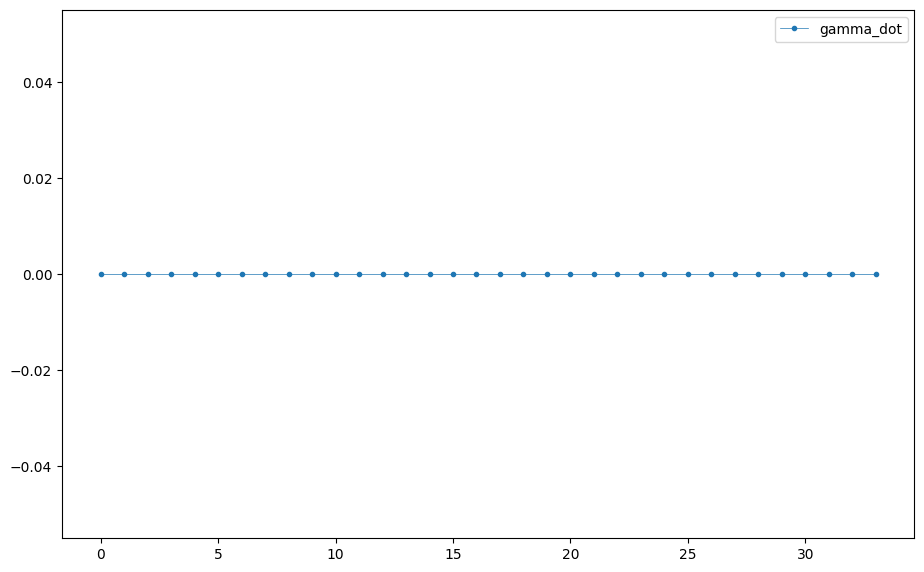

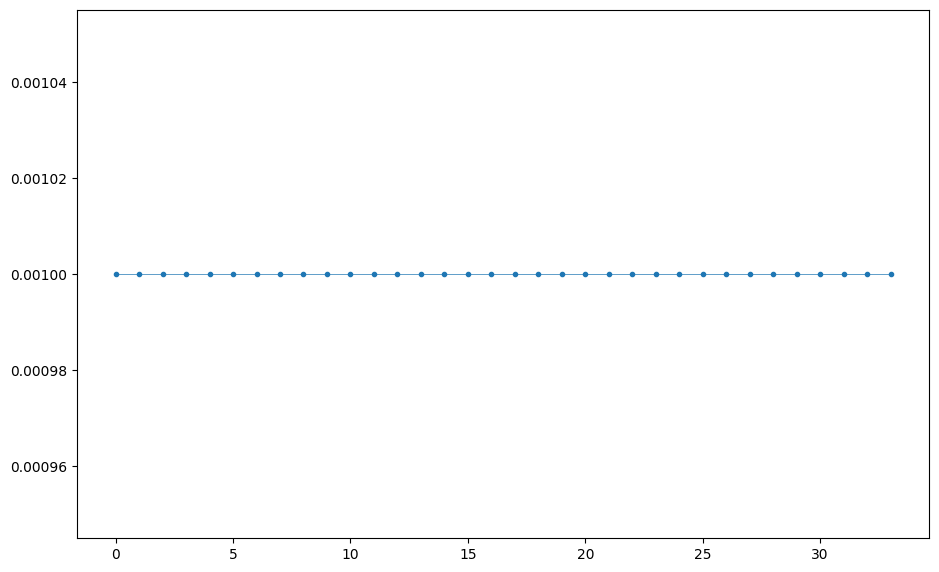

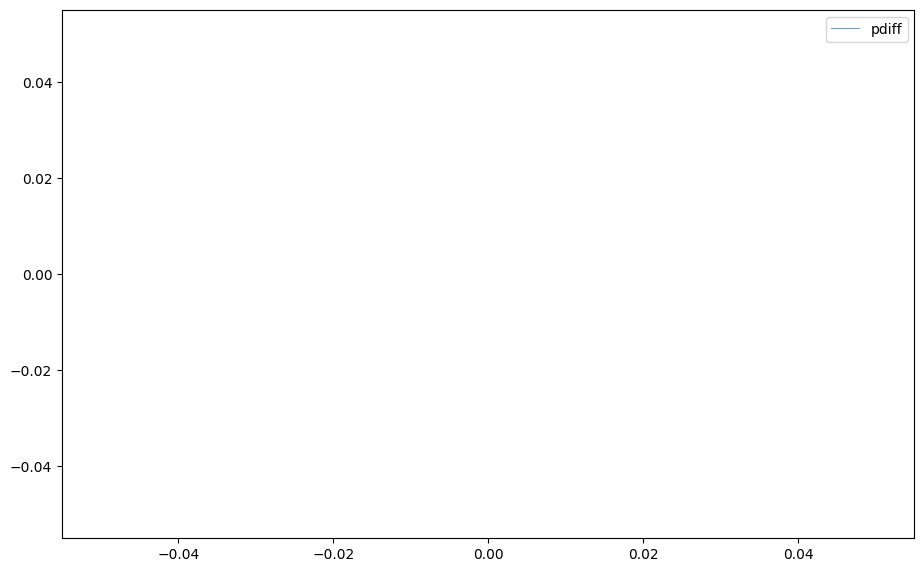

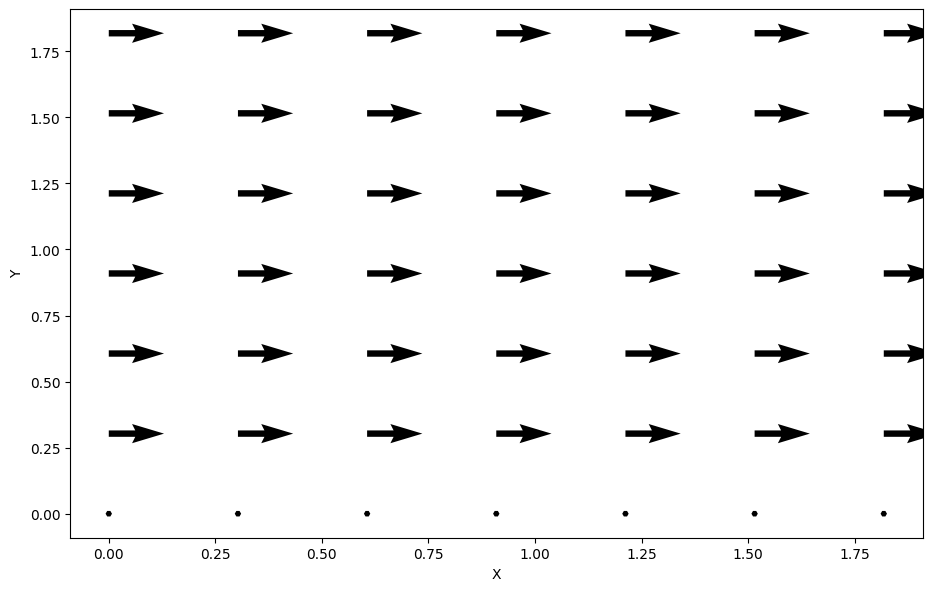

In [28]:
%time u, v, p, vel_anal, nu1, gamma_dot, S11, S12, S22, plotpdiff = chn_sim_run(1.4,9)

7120 1.010747831577119e-06 0.05850226791995236 0.5652348554221921
7127
U_maximum: 0.05850227726962194
CPU times: user 30 s, sys: 3.3 s, total: 33.3 s
Wall time: 32.2 s


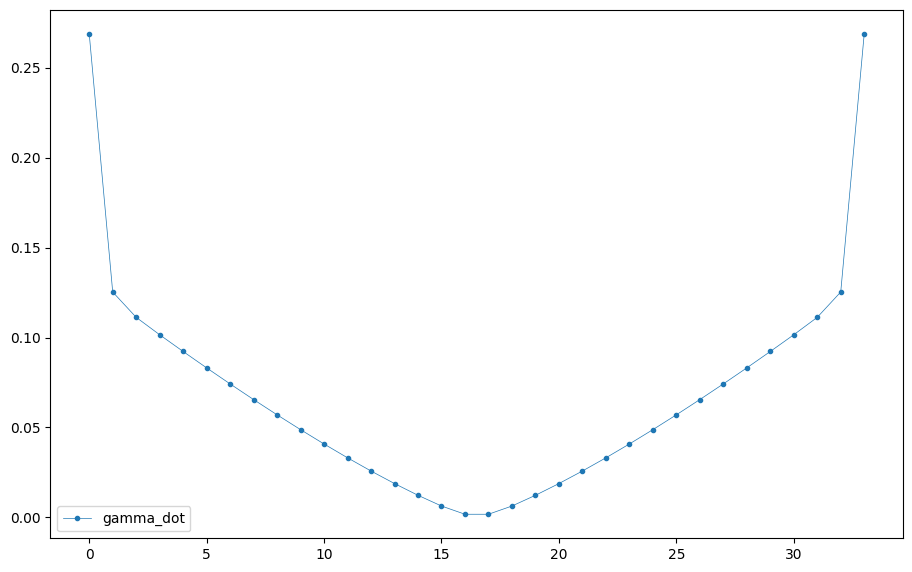

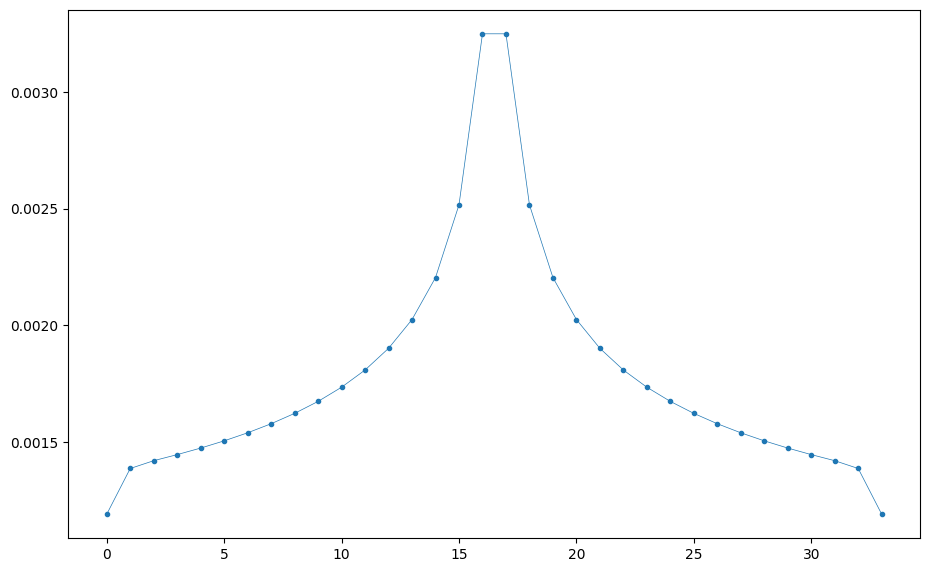

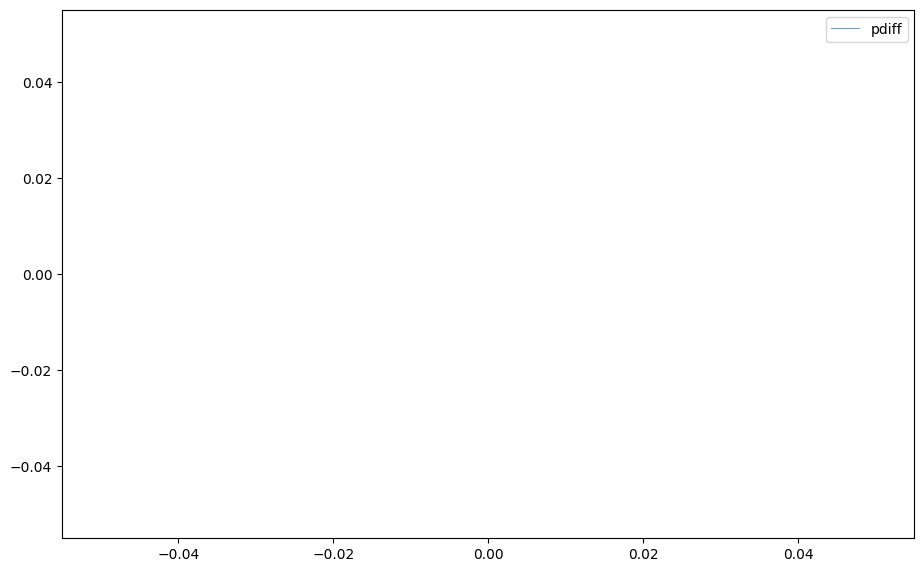

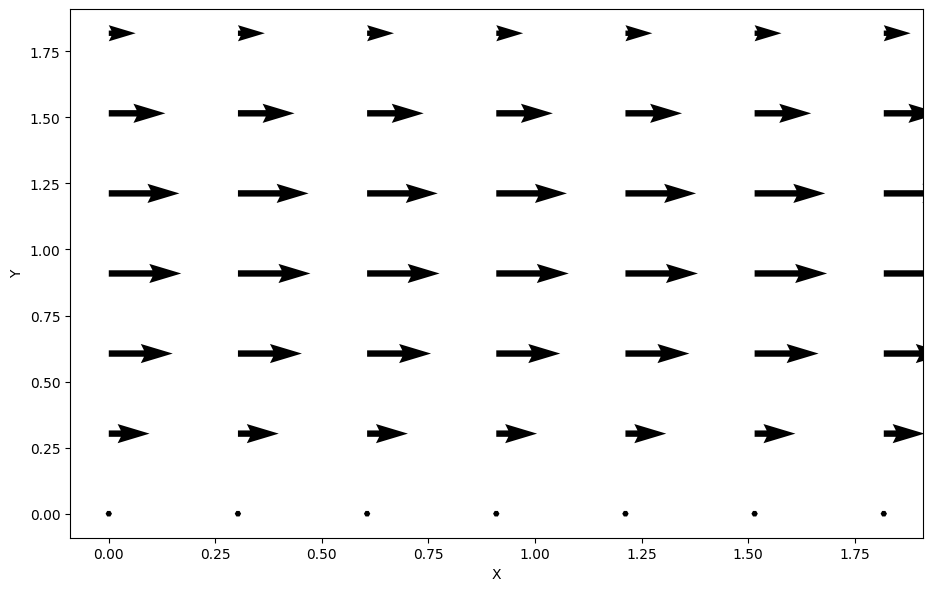

In [29]:
%time u, v, p, vel_anal, nu1, gamma_dot, S11, S12, S22, plotpdiff = chn_sim_run(0.8,1e-6)

Maximum Velocity: 0.05850227726962194
Maximum Analytical Velocity: 0.057755641506445486


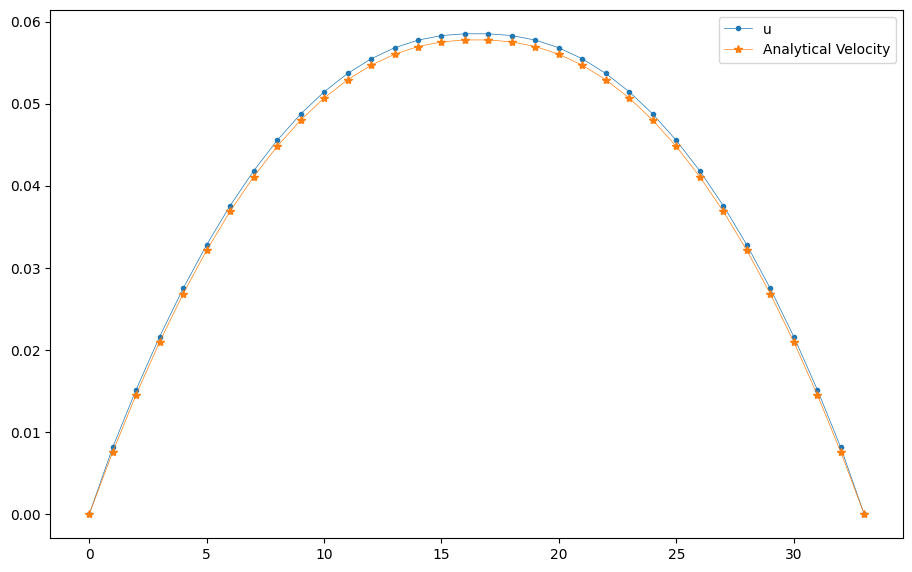

In [30]:
fig = plt.figure(figsize=(11, 7), dpi=100)
plt.plot(u[:,20], marker = '.', lw=0.5, label='u')
plt.plot(vel_anal, marker = '*', lw=0.5, label='Analytical Velocity')
plt.legend()
print("Maximum Velocity:", np.max(u))
print("Maximum Analytical Velocity:", np.max(vel_anal))

In [31]:
np.sum(np.abs(u[:,20] - vel_anal)) / np.sum(np.abs(vel_anal))

0.017331136082475915

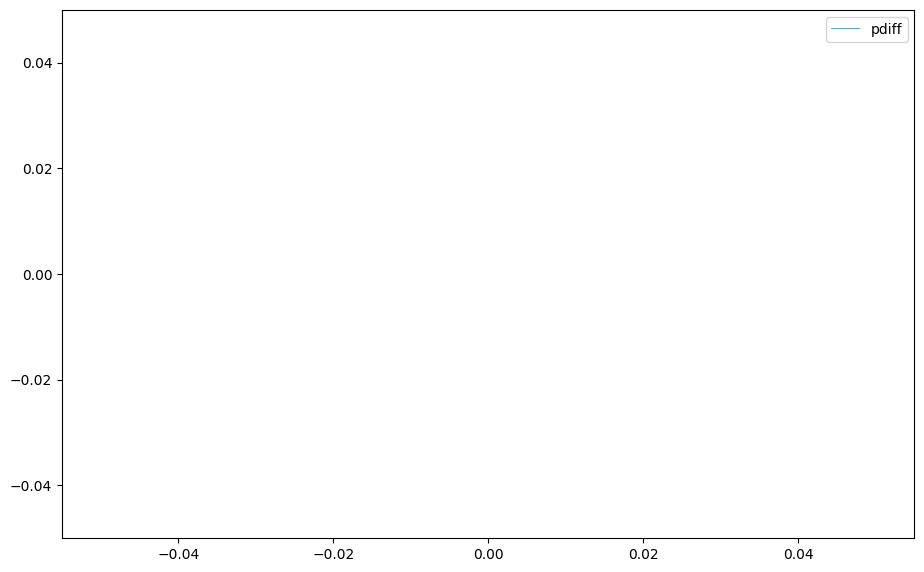

In [32]:
fig = plt.figure(figsize = (11, 7), dpi = 100)
plt.plot(plotpdiff, lw = 0.5, label = 'pdiff')
plt.ylim((0,1e-317))
plt.legend()

In [33]:
plotpdiff

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan])

1820 1.040204561275149e-06 0.001198578037026756 0.018365472910927456
1829
U_maximum: 0.001198590845553014
CPU times: user 8.52 s, sys: 860 ms, total: 9.38 s
Wall time: 9.06 s


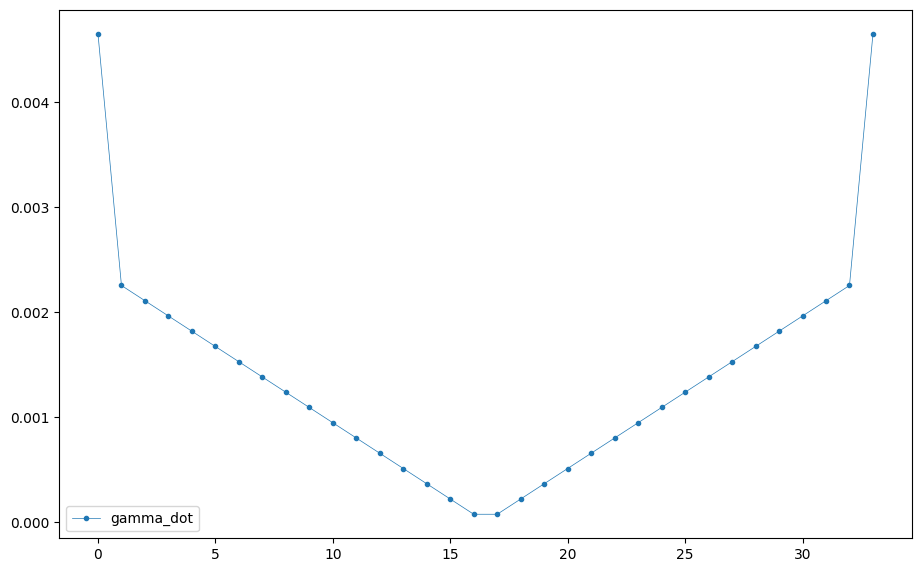

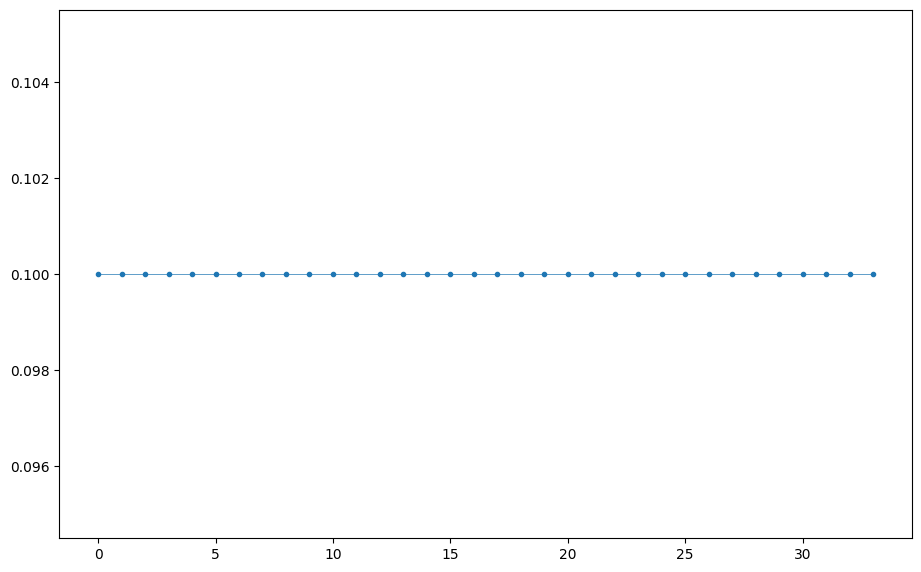

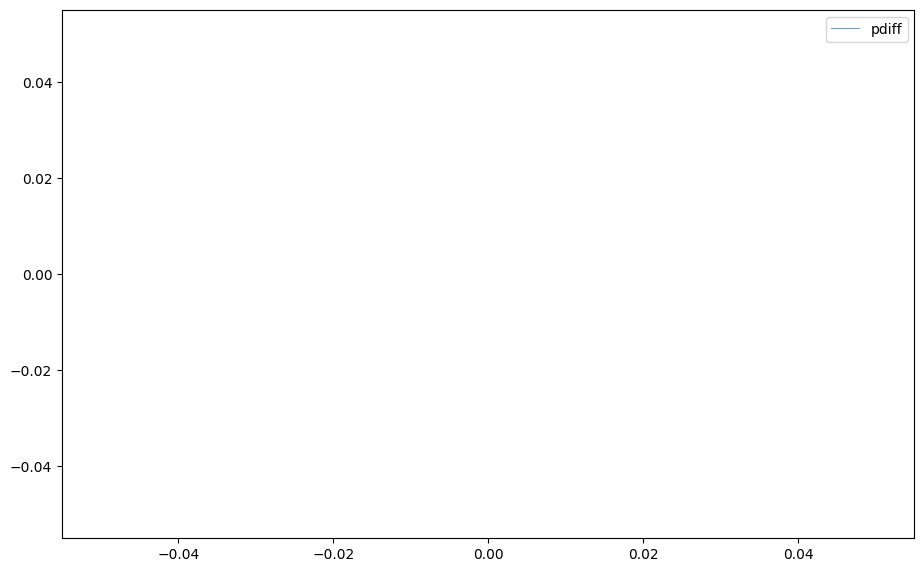

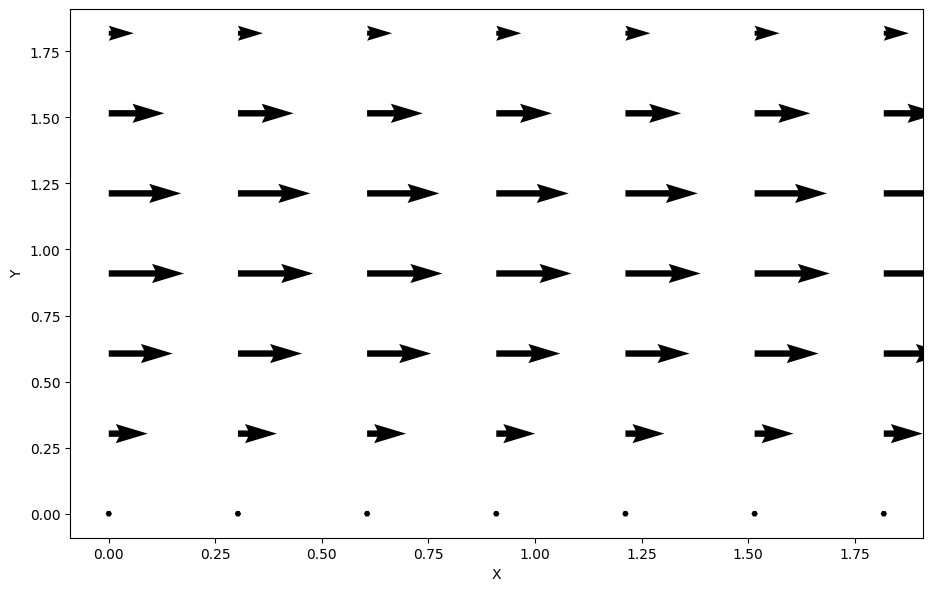

In [36]:
%time u, v, p, vel_anal, nu1, gamma_dot, S11, S12, S22, plotpdiff = chn_sim_run(1,1e-6)

Maximum Velocity: 0.001198590845553014
Maximum Analytical Velocity: 0.0011988980716253444


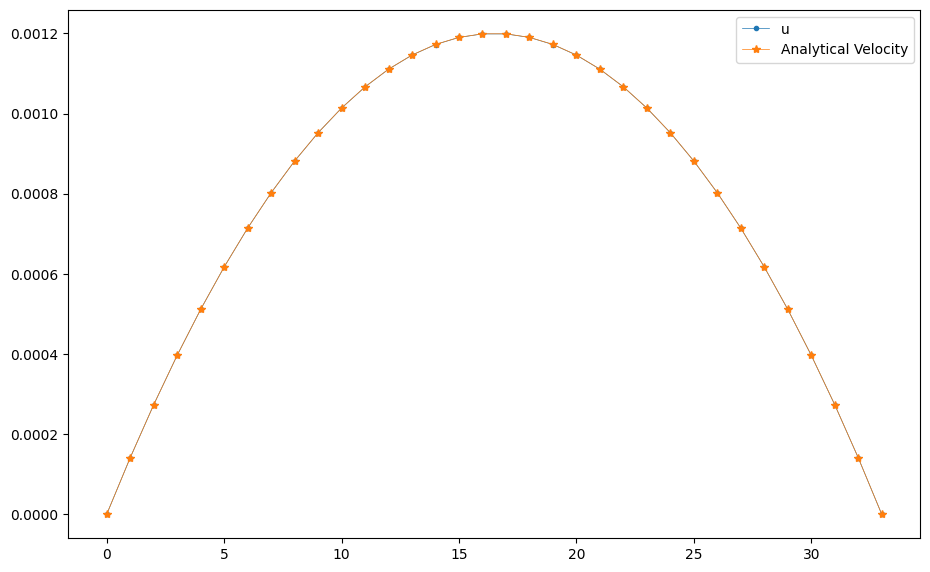

In [37]:
fig = plt.figure(figsize=(11, 7), dpi=100)
plt.plot(u[:,20], marker = '.', lw=0.5, label='u')
plt.plot(vel_anal, marker = '*', lw=0.5, label='Analytical Velocity')
plt.legend()
print("Maximum Velocity:", np.max(u))
print("Maximum Analytical Velocity:", np.max(vel_anal))
